# DQAN: DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [3]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.00222694 -0.22294398 -0.01775856  0.29077372] 0 1.0 False {}
state, action, reward, done, info
[-0.00223194 -0.02757337 -0.01194309 -0.00745672] 1 1.0 False {}
state, action, reward, done, info
[-0.00278341  0.16771781 -0.01209222 -0.30388378] 1 1.0 False {}
state, action, reward, done, info
[ 0.00057095 -0.02722974 -0.0181699  -0.01503886] 0 1.0 False {}
state, action, reward, done, info
[ 2.63533246e-05  1.68148013e-01 -1.84706775e-02 -3.13398773e-01] 1 1.0 False {}
state, action, reward, done, info
[ 0.00338931  0.36352815 -0.02473865 -0.61184906] 1 1.0 False {}
state, action, reward, done, info
[ 0.01065988  0.55898696 -0.03697563 -0.91221999] 1 1.0 False {}
state, action, reward, done, info
[ 0.02183962  0.75458915 -0.05522003 -1.21629107] 1 1.0 False {}
state, action, reward, done, info
[ 0.0369314   0.95037813 -0.07954586 -1.52575334] 1 1.0 False {}
state, action, reward, done, info
[ 0.05593896  1.14636506 -0.11006092 -1.84216597] 1 1.0 Fal

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.146365057513399 -1.8421659689688057


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [7]:
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        return logits

In [8]:
def discriminator(actions, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [9]:
def model_loss(states, actions, action_size, hidden_size, state_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, 
                               state_size=state_size)
    actions_fake = tf.nn.softmax(actions_logits)
    d_logits_fake = discriminator(actions=actions_fake, hidden_size=hidden_size, action_size=action_size)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    d_logits_real = discriminator(actions=actions_real, hidden_size=hidden_size, action_size=action_size, 
                                  reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake

In [10]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [12]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, states=self.states, 
            hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [15]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 
rewards_fake_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        d_loss, g_loss, q_loss = 0, 0, 0
        rewards_fake_mean = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            # feed_dict={model.states: next_states}
            # next_actions_logits, next_rewards_fake = sess.run([model.actions_logits, model.rewards_fake], feed_dict)
            feed_dict={model.states: states}
            rewards_fake = sess.run(model.rewards_fake, feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake rewards or rewarded generated actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            # print('DEBUGGING', targetQs.shape, next_rewards_fake.shape, next_actions_logits.shape, np.max(next_actions_logits, axis=1).shape)

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.targetQs: targetQs}
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

Episode: 0 Total reward: 5.0 Average reward fake: 0.5388237833976746 Training d_loss: 1.3556 Training g_loss: 0.6301 Training q_loss: 0.5420 Explore P: 0.9995
Episode: 1 Total reward: 12.0 Average reward fake: 0.49096670746803284 Training d_loss: 1.2933 Training g_loss: 0.7199 Training q_loss: 0.9145 Explore P: 0.9983
Episode: 2 Total reward: 20.0 Average reward fake: 0.4301253855228424 Training d_loss: 1.1584 Training g_loss: 0.8514 Training q_loss: 2.1964 Explore P: 0.9963
Episode: 3 Total reward: 15.0 Average reward fake: 0.4589077830314636 Training d_loss: 1.1449 Training g_loss: 0.7866 Training q_loss: 2.7261 Explore P: 0.9949
Episode: 4 Total reward: 15.0 Average reward fake: 0.5174843072891235 Training d_loss: 1.2871 Training g_loss: 0.6998 Training q_loss: 5.9500 Explore P: 0.9934
Episode: 5 Total reward: 16.0 Average reward fake: 0.4305177628993988 Training d_loss: 1.2738 Training g_loss: 0.8692 Training q_loss: 7.6100 Explore P: 0.9918
Episode: 6 Total reward: 13.0 Average re

Episode: 51 Total reward: 12.0 Average reward fake: 0.3582882881164551 Training d_loss: 0.7544 Training g_loss: 1.0230 Training q_loss: 2180215.5000 Explore P: 0.9088
Episode: 52 Total reward: 13.0 Average reward fake: 0.3536151051521301 Training d_loss: 1.0615 Training g_loss: 1.0521 Training q_loss: 544316.8125 Explore P: 0.9076
Episode: 53 Total reward: 18.0 Average reward fake: 0.3740648925304413 Training d_loss: 1.0597 Training g_loss: 0.9943 Training q_loss: 258439.9688 Explore P: 0.9060
Episode: 54 Total reward: 14.0 Average reward fake: 0.339749276638031 Training d_loss: 1.1717 Training g_loss: 1.0621 Training q_loss: 281842.2188 Explore P: 0.9047
Episode: 55 Total reward: 36.0 Average reward fake: 0.3528996407985687 Training d_loss: 1.0610 Training g_loss: 1.0554 Training q_loss: 234653.7188 Explore P: 0.9015
Episode: 56 Total reward: 20.0 Average reward fake: 0.38108938932418823 Training d_loss: 1.0594 Training g_loss: 0.9604 Training q_loss: 242256.0469 Explore P: 0.8997
Epi

Episode: 101 Total reward: 24.0 Average reward fake: 0.3515334725379944 Training d_loss: 1.0605 Training g_loss: 1.0405 Training q_loss: 5253190.5000 Explore P: 0.8209
Episode: 102 Total reward: 19.0 Average reward fake: 0.3589852452278137 Training d_loss: 0.7521 Training g_loss: 1.0335 Training q_loss: 5764673.5000 Explore P: 0.8193
Episode: 103 Total reward: 37.0 Average reward fake: 0.37266018986701965 Training d_loss: 0.8612 Training g_loss: 0.9965 Training q_loss: 7451657.5000 Explore P: 0.8163
Episode: 104 Total reward: 21.0 Average reward fake: 0.389329731464386 Training d_loss: 0.9649 Training g_loss: 0.9339 Training q_loss: 73707.2266 Explore P: 0.8146
Episode: 105 Total reward: 17.0 Average reward fake: 0.33311206102371216 Training d_loss: 1.0647 Training g_loss: 1.1058 Training q_loss: 49363.9727 Explore P: 0.8133
Episode: 106 Total reward: 19.0 Average reward fake: 0.3300195336341858 Training d_loss: 0.9549 Training g_loss: 1.1082 Training q_loss: 4491161.0000 Explore P: 0.

Episode: 151 Total reward: 14.0 Average reward fake: 0.316053181886673 Training d_loss: 0.9575 Training g_loss: 1.1453 Training q_loss: 2334490.2500 Explore P: 0.7515
Episode: 152 Total reward: 13.0 Average reward fake: 0.34241461753845215 Training d_loss: 0.7427 Training g_loss: 1.0736 Training q_loss: 2005002.7500 Explore P: 0.7506
Episode: 153 Total reward: 19.0 Average reward fake: 0.3723856806755066 Training d_loss: 1.1580 Training g_loss: 0.9836 Training q_loss: 1083659.3750 Explore P: 0.7492
Episode: 154 Total reward: 13.0 Average reward fake: 0.37017446756362915 Training d_loss: 1.1586 Training g_loss: 0.9888 Training q_loss: 1762105.3750 Explore P: 0.7482
Episode: 155 Total reward: 14.0 Average reward fake: 0.3570994734764099 Training d_loss: 1.0604 Training g_loss: 1.0388 Training q_loss: 11258.4395 Explore P: 0.7472
Episode: 156 Total reward: 16.0 Average reward fake: 0.35888364911079407 Training d_loss: 0.8555 Training g_loss: 1.0079 Training q_loss: 17676.1406 Explore P: 0

Episode: 201 Total reward: 15.0 Average reward fake: 0.43040671944618225 Training d_loss: 1.2745 Training g_loss: 0.8579 Training q_loss: 12676.9082 Explore P: 0.6891
Episode: 202 Total reward: 10.0 Average reward fake: 0.4212876260280609 Training d_loss: 1.3303 Training g_loss: 0.8844 Training q_loss: 166532.3281 Explore P: 0.6884
Episode: 203 Total reward: 8.0 Average reward fake: 0.5832405686378479 Training d_loss: 1.3190 Training g_loss: 0.5857 Training q_loss: 141719.6406 Explore P: 0.6878
Episode: 204 Total reward: 11.0 Average reward fake: 0.6719344854354858 Training d_loss: 1.8044 Training g_loss: 0.4134 Training q_loss: 14665.1426 Explore P: 0.6871
Episode: 205 Total reward: 32.0 Average reward fake: 0.496285617351532 Training d_loss: 1.3800 Training g_loss: 0.7093 Training q_loss: 121943.5625 Explore P: 0.6849
Episode: 206 Total reward: 13.0 Average reward fake: 0.41837078332901 Training d_loss: 1.3572 Training g_loss: 0.8893 Training q_loss: 11143.4424 Explore P: 0.6841
Epis

Episode: 252 Total reward: 11.0 Average reward fake: 0.5905638933181763 Training d_loss: 1.5069 Training g_loss: 0.5356 Training q_loss: 98573.9688 Explore P: 0.6431
Episode: 253 Total reward: 26.0 Average reward fake: 0.5471531748771667 Training d_loss: 1.4159 Training g_loss: 0.6053 Training q_loss: 25863.8555 Explore P: 0.6415
Episode: 254 Total reward: 14.0 Average reward fake: 0.5356682538986206 Training d_loss: 1.4108 Training g_loss: 0.6253 Training q_loss: 26468.0898 Explore P: 0.6406
Episode: 255 Total reward: 16.0 Average reward fake: 0.5294852256774902 Training d_loss: 1.3813 Training g_loss: 0.6366 Training q_loss: 20277.6309 Explore P: 0.6396
Episode: 256 Total reward: 8.0 Average reward fake: 0.5288880467414856 Training d_loss: 1.3621 Training g_loss: 0.6375 Training q_loss: 88570.2031 Explore P: 0.6391
Episode: 257 Total reward: 20.0 Average reward fake: 0.5318588018417358 Training d_loss: 1.3473 Training g_loss: 0.6332 Training q_loss: 72386.8047 Explore P: 0.6379
Episo

Episode: 303 Total reward: 9.0 Average reward fake: 0.3571712374687195 Training d_loss: 1.0597 Training g_loss: 1.0289 Training q_loss: 19609.5586 Explore P: 0.5935
Episode: 304 Total reward: 27.0 Average reward fake: 0.37902823090553284 Training d_loss: 0.9617 Training g_loss: 0.9675 Training q_loss: 22935.7930 Explore P: 0.5919
Episode: 305 Total reward: 33.0 Average reward fake: 0.3846898674964905 Training d_loss: 0.6769 Training g_loss: 0.9577 Training q_loss: 22924.5352 Explore P: 0.5900
Episode: 306 Total reward: 16.0 Average reward fake: 0.3706488013267517 Training d_loss: 1.1579 Training g_loss: 0.9902 Training q_loss: 27104.9805 Explore P: 0.5891
Episode: 307 Total reward: 9.0 Average reward fake: 0.3702675700187683 Training d_loss: 1.3567 Training g_loss: 0.9932 Training q_loss: 27867.4180 Explore P: 0.5885
Episode: 308 Total reward: 14.0 Average reward fake: 0.37061381340026855 Training d_loss: 1.0587 Training g_loss: 0.9899 Training q_loss: 19032.9141 Explore P: 0.5877
Epis

Episode: 353 Total reward: 30.0 Average reward fake: 0.4892241358757019 Training d_loss: 1.3835 Training g_loss: 0.7155 Training q_loss: 7931.1143 Explore P: 0.4976
Episode: 354 Total reward: 53.0 Average reward fake: 0.5029471516609192 Training d_loss: 1.3889 Training g_loss: 0.6868 Training q_loss: 6537.5747 Explore P: 0.4950
Episode: 355 Total reward: 58.0 Average reward fake: 0.5026527047157288 Training d_loss: 1.3567 Training g_loss: 0.6938 Training q_loss: 3406.7859 Explore P: 0.4922
Episode: 356 Total reward: 25.0 Average reward fake: 0.4939681589603424 Training d_loss: 1.3895 Training g_loss: 0.7087 Training q_loss: 3875.7942 Explore P: 0.4910
Episode: 357 Total reward: 23.0 Average reward fake: 0.4869351387023926 Training d_loss: 1.3985 Training g_loss: 0.7199 Training q_loss: 1946.8033 Explore P: 0.4899
Episode: 358 Total reward: 22.0 Average reward fake: 0.4879387319087982 Training d_loss: 1.3847 Training g_loss: 0.7176 Training q_loss: 4372.6846 Explore P: 0.4889
Episode: 3

Episode: 403 Total reward: 48.0 Average reward fake: 0.5044032335281372 Training d_loss: 1.3852 Training g_loss: 0.6845 Training q_loss: 1584.8752 Explore P: 0.4165
Episode: 404 Total reward: 34.0 Average reward fake: 0.5015589594841003 Training d_loss: 1.3802 Training g_loss: 0.6905 Training q_loss: 5881.0605 Explore P: 0.4151
Episode: 405 Total reward: 43.0 Average reward fake: 0.4983099102973938 Training d_loss: 1.3915 Training g_loss: 0.6968 Training q_loss: 9615.0557 Explore P: 0.4134
Episode: 406 Total reward: 22.0 Average reward fake: 0.49977725744247437 Training d_loss: 1.3883 Training g_loss: 0.6943 Training q_loss: 1123.1042 Explore P: 0.4125
Episode: 407 Total reward: 60.0 Average reward fake: 0.4930174946784973 Training d_loss: 1.4049 Training g_loss: 0.7069 Training q_loss: 1432.1559 Explore P: 0.4101
Episode: 408 Total reward: 53.0 Average reward fake: 0.49399298429489136 Training d_loss: 1.3594 Training g_loss: 0.7072 Training q_loss: 910.4214 Explore P: 0.4079
Episode: 

Episode: 453 Total reward: 35.0 Average reward fake: 0.4987994134426117 Training d_loss: 1.3810 Training g_loss: 0.6957 Training q_loss: 287.4337 Explore P: 0.3499
Episode: 454 Total reward: 30.0 Average reward fake: 0.5001438856124878 Training d_loss: 1.3869 Training g_loss: 0.6933 Training q_loss: 2699.0012 Explore P: 0.3489
Episode: 455 Total reward: 21.0 Average reward fake: 0.4993663430213928 Training d_loss: 1.3863 Training g_loss: 0.6944 Training q_loss: 477.6427 Explore P: 0.3482
Episode: 456 Total reward: 105.0 Average reward fake: 0.4908375144004822 Training d_loss: 1.3692 Training g_loss: 0.7132 Training q_loss: 380.8844 Explore P: 0.3447
Episode: 457 Total reward: 85.0 Average reward fake: 0.5114012956619263 Training d_loss: 1.4272 Training g_loss: 0.6765 Training q_loss: 629.1377 Explore P: 0.3418
Episode: 458 Total reward: 18.0 Average reward fake: 0.49789899587631226 Training d_loss: 1.3802 Training g_loss: 0.6994 Training q_loss: 1469.0265 Explore P: 0.3412
Episode: 459

Episode: 503 Total reward: 57.0 Average reward fake: 0.5005965232849121 Training d_loss: 1.3899 Training g_loss: 0.6945 Training q_loss: 255.0407 Explore P: 0.2798
Episode: 504 Total reward: 31.0 Average reward fake: 0.4874843955039978 Training d_loss: 1.3651 Training g_loss: 0.7219 Training q_loss: 461.7119 Explore P: 0.2789
Episode: 505 Total reward: 54.0 Average reward fake: 0.512789249420166 Training d_loss: 1.3909 Training g_loss: 0.6685 Training q_loss: 12180.1670 Explore P: 0.2775
Episode: 506 Total reward: 29.0 Average reward fake: 0.4995841383934021 Training d_loss: 1.3826 Training g_loss: 0.6946 Training q_loss: 354.3730 Explore P: 0.2767
Episode: 507 Total reward: 20.0 Average reward fake: 0.4767315983772278 Training d_loss: 1.3603 Training g_loss: 0.7460 Training q_loss: 6531.6631 Explore P: 0.2762
Episode: 508 Total reward: 32.0 Average reward fake: 0.5192424654960632 Training d_loss: 1.3855 Training g_loss: 0.6558 Training q_loss: 465.4389 Explore P: 0.2753
Episode: 509 T

Episode: 553 Total reward: 60.0 Average reward fake: 0.48765498399734497 Training d_loss: 1.3686 Training g_loss: 0.7212 Training q_loss: 13916.8594 Explore P: 0.2160
Episode: 554 Total reward: 102.0 Average reward fake: 0.5119268298149109 Training d_loss: 1.3702 Training g_loss: 0.6706 Training q_loss: 9790.9863 Explore P: 0.2139
Episode: 555 Total reward: 92.0 Average reward fake: 0.4572151303291321 Training d_loss: 1.3154 Training g_loss: 0.8584 Training q_loss: 161.3067 Explore P: 0.2120
Episode: 556 Total reward: 79.0 Average reward fake: 0.4745756983757019 Training d_loss: 1.3579 Training g_loss: 0.7475 Training q_loss: 326.9476 Explore P: 0.2104
Episode: 557 Total reward: 65.0 Average reward fake: 0.4919326901435852 Training d_loss: 1.3517 Training g_loss: 0.7157 Training q_loss: 198.4046 Explore P: 0.2091
Episode: 558 Total reward: 65.0 Average reward fake: 0.5008254647254944 Training d_loss: 1.3338 Training g_loss: 0.6979 Training q_loss: 89.2877 Explore P: 0.2078
Episode: 559

Episode: 603 Total reward: 101.0 Average reward fake: 0.3834112286567688 Training d_loss: 1.2371 Training g_loss: 1.2317 Training q_loss: 267.1182 Explore P: 0.1319
Episode: 604 Total reward: 190.0 Average reward fake: 0.4246577322483063 Training d_loss: 1.2445 Training g_loss: 0.9182 Training q_loss: 196.3612 Explore P: 0.1296
Episode: 605 Total reward: 199.0 Average reward fake: 0.4988320469856262 Training d_loss: 1.3824 Training g_loss: 0.6977 Training q_loss: 175.8946 Explore P: 0.1272
Episode: 606 Total reward: 152.0 Average reward fake: 0.5054890513420105 Training d_loss: 1.3457 Training g_loss: 1.0079 Training q_loss: 363.1105 Explore P: 0.1255
Episode: 607 Total reward: 199.0 Average reward fake: 0.4908926486968994 Training d_loss: 1.3667 Training g_loss: 0.7240 Training q_loss: 166.6105 Explore P: 0.1232
Episode: 608 Total reward: 199.0 Average reward fake: 0.4083707928657532 Training d_loss: 1.2944 Training g_loss: 1.5753 Training q_loss: 280.5509 Explore P: 0.1210
Episode: 6

Episode: 653 Total reward: 199.0 Average reward fake: 0.5038773417472839 Training d_loss: 1.3384 Training g_loss: 1.0996 Training q_loss: 178.5770 Explore P: 0.0853
Episode: 654 Total reward: 194.0 Average reward fake: 0.4521295130252838 Training d_loss: 1.4062 Training g_loss: 0.8116 Training q_loss: 269.5097 Explore P: 0.0838
Episode: 655 Total reward: 199.0 Average reward fake: 0.4492630064487457 Training d_loss: 1.2938 Training g_loss: 1.2379 Training q_loss: 131.3466 Explore P: 0.0824
Episode: 656 Total reward: 199.0 Average reward fake: 0.39636602997779846 Training d_loss: 1.2350 Training g_loss: 0.9761 Training q_loss: 6641.4229 Explore P: 0.0810
Episode: 657 Total reward: 199.0 Average reward fake: 0.39676356315612793 Training d_loss: 1.4306 Training g_loss: 0.9532 Training q_loss: 567.2509 Explore P: 0.0796
Episode: 658 Total reward: 189.0 Average reward fake: 0.4739746153354645 Training d_loss: 1.3332 Training g_loss: 0.7647 Training q_loss: 487.6556 Explore P: 0.0783
Episode

Episode: 703 Total reward: 199.0 Average reward fake: 0.49377408623695374 Training d_loss: 1.3191 Training g_loss: 0.7611 Training q_loss: 151.2204 Explore P: 0.0381
Episode: 704 Total reward: 197.0 Average reward fake: 0.38235655426979065 Training d_loss: 1.0743 Training g_loss: 2.0383 Training q_loss: 32.9227 Explore P: 0.0376
Episode: 705 Total reward: 167.0 Average reward fake: 0.26564639806747437 Training d_loss: 0.9398 Training g_loss: 4.4013 Training q_loss: 66.1194 Explore P: 0.0371
Episode: 706 Total reward: 199.0 Average reward fake: 0.4088762402534485 Training d_loss: 1.1665 Training g_loss: 2.1936 Training q_loss: 44.1580 Explore P: 0.0366
Episode: 707 Total reward: 199.0 Average reward fake: 0.37487703561782837 Training d_loss: 1.1508 Training g_loss: 3.0339 Training q_loss: 88.9330 Explore P: 0.0360
Episode: 708 Total reward: 199.0 Average reward fake: 0.5430618524551392 Training d_loss: 1.3515 Training g_loss: 1.6713 Training q_loss: 37.7320 Explore P: 0.0355
Episode: 70

Episode: 753 Total reward: 9.0 Average reward fake: 0.3010030686855316 Training d_loss: 1.0788 Training g_loss: 1.1880 Training q_loss: 321992.1562 Explore P: 0.0289
Episode: 754 Total reward: 11.0 Average reward fake: 0.33519867062568665 Training d_loss: 0.6274 Training g_loss: 1.1001 Training q_loss: 359293.4688 Explore P: 0.0289
Episode: 755 Total reward: 11.0 Average reward fake: 0.2885369658470154 Training d_loss: 0.8380 Training g_loss: 1.2579 Training q_loss: 181230.3906 Explore P: 0.0289
Episode: 756 Total reward: 7.0 Average reward fake: 0.29305723309516907 Training d_loss: 0.7155 Training g_loss: 1.2188 Training q_loss: 189928.5469 Explore P: 0.0289
Episode: 757 Total reward: 11.0 Average reward fake: 0.29532742500305176 Training d_loss: 0.9602 Training g_loss: 1.2068 Training q_loss: 91280.7344 Explore P: 0.0288
Episode: 758 Total reward: 10.0 Average reward fake: 0.35570529103279114 Training d_loss: 1.0600 Training g_loss: 1.0194 Training q_loss: 65278.3047 Explore P: 0.028

Episode: 804 Total reward: 14.0 Average reward fake: 0.32707592844963074 Training d_loss: 0.6260 Training g_loss: 1.1247 Training q_loss: 13140941.0000 Explore P: 0.0274
Episode: 805 Total reward: 113.0 Average reward fake: 0.4506555199623108 Training d_loss: 1.2275 Training g_loss: 0.8976 Training q_loss: 5378.8154 Explore P: 0.0272
Episode: 806 Total reward: 81.0 Average reward fake: 0.33591052889823914 Training d_loss: 0.9271 Training g_loss: 1.0964 Training q_loss: 18101.8535 Explore P: 0.0270
Episode: 807 Total reward: 25.0 Average reward fake: 0.4055918753147125 Training d_loss: 1.1914 Training g_loss: 0.9426 Training q_loss: 5136.9697 Explore P: 0.0270
Episode: 808 Total reward: 14.0 Average reward fake: 0.3310618996620178 Training d_loss: 0.8846 Training g_loss: 1.1061 Training q_loss: 4373.3564 Explore P: 0.0270
Episode: 809 Total reward: 11.0 Average reward fake: 0.3169332444667816 Training d_loss: 1.1981 Training g_loss: 1.1436 Training q_loss: 890.3758 Explore P: 0.0269
Epi

Episode: 855 Total reward: 11.0 Average reward fake: 0.3009806275367737 Training d_loss: 1.0804 Training g_loss: 1.2024 Training q_loss: 15206094.0000 Explore P: 0.0262
Episode: 856 Total reward: 9.0 Average reward fake: 0.30523499846458435 Training d_loss: 1.0785 Training g_loss: 1.1729 Training q_loss: 6213.6777 Explore P: 0.0262
Episode: 857 Total reward: 12.0 Average reward fake: 0.369243323802948 Training d_loss: 1.0625 Training g_loss: 0.9864 Training q_loss: 2183.0464 Explore P: 0.0261
Episode: 858 Total reward: 13.0 Average reward fake: 0.36755600571632385 Training d_loss: 0.7687 Training g_loss: 1.0119 Training q_loss: 1090.1156 Explore P: 0.0261
Episode: 859 Total reward: 15.0 Average reward fake: 0.3265523314476013 Training d_loss: 1.0762 Training g_loss: 1.1305 Training q_loss: 1755.3711 Explore P: 0.0261
Episode: 860 Total reward: 10.0 Average reward fake: 0.30411362648010254 Training d_loss: 0.7386 Training g_loss: 1.1990 Training q_loss: 7269.1846 Explore P: 0.0261
Episo

Episode: 905 Total reward: 37.0 Average reward fake: 0.4187045693397522 Training d_loss: 1.1026 Training g_loss: 0.8925 Training q_loss: 5436.8560 Explore P: 0.0239
Episode: 906 Total reward: 45.0 Average reward fake: 0.5073176622390747 Training d_loss: 1.5434 Training g_loss: 0.7320 Training q_loss: 243574.5469 Explore P: 0.0239
Episode: 907 Total reward: 37.0 Average reward fake: 0.36496812105178833 Training d_loss: 1.3091 Training g_loss: 1.0117 Training q_loss: 1175.8796 Explore P: 0.0238
Episode: 908 Total reward: 18.0 Average reward fake: 0.3227717876434326 Training d_loss: 0.9649 Training g_loss: 1.1264 Training q_loss: 3597.0481 Explore P: 0.0238
Episode: 909 Total reward: 18.0 Average reward fake: 0.39723077416419983 Training d_loss: 1.1295 Training g_loss: 0.9197 Training q_loss: 3141.5356 Explore P: 0.0238
Episode: 910 Total reward: 27.0 Average reward fake: 0.3509829640388489 Training d_loss: 1.1203 Training g_loss: 1.0294 Training q_loss: 761069.8125 Explore P: 0.0237
Epis

Episode: 955 Total reward: 26.0 Average reward fake: 0.29919877648353577 Training d_loss: 0.9062 Training g_loss: 2.7338 Training q_loss: 4552.7100 Explore P: 0.0196
Episode: 956 Total reward: 199.0 Average reward fake: 0.49241048097610474 Training d_loss: 1.3400 Training g_loss: 0.7222 Training q_loss: 13873.7471 Explore P: 0.0194
Episode: 957 Total reward: 84.0 Average reward fake: 0.5182303190231323 Training d_loss: 1.3556 Training g_loss: 0.6609 Training q_loss: 529.8613 Explore P: 0.0193
Episode: 958 Total reward: 152.0 Average reward fake: 0.5172727704048157 Training d_loss: 1.3872 Training g_loss: 0.6585 Training q_loss: 59275.5859 Explore P: 0.0192
Episode: 959 Total reward: 125.0 Average reward fake: 0.5048814415931702 Training d_loss: 1.3762 Training g_loss: 0.6848 Training q_loss: 2735.9438 Explore P: 0.0191
Episode: 960 Total reward: 199.0 Average reward fake: 0.4221152365207672 Training d_loss: 1.2595 Training g_loss: 1.3144 Training q_loss: 42858.9688 Explore P: 0.0189
Ep

Episode: 1005 Total reward: 143.0 Average reward fake: 0.5271464586257935 Training d_loss: 1.3544 Training g_loss: 0.6601 Training q_loss: 4281.3696 Explore P: 0.0149
Episode: 1006 Total reward: 199.0 Average reward fake: 0.3527378439903259 Training d_loss: 0.9700 Training g_loss: 1.8675 Training q_loss: 252.8072 Explore P: 0.0148
Episode: 1007 Total reward: 32.0 Average reward fake: 0.40896812081336975 Training d_loss: 1.1346 Training g_loss: 0.9238 Training q_loss: 30960.2227 Explore P: 0.0148
Episode: 1008 Total reward: 199.0 Average reward fake: 0.4065670967102051 Training d_loss: 1.2749 Training g_loss: 1.0334 Training q_loss: 22515.0820 Explore P: 0.0147
Episode: 1009 Total reward: 199.0 Average reward fake: 0.5237026214599609 Training d_loss: 1.3460 Training g_loss: 0.6464 Training q_loss: 444.4456 Explore P: 0.0146
Episode: 1010 Total reward: 109.0 Average reward fake: 0.591812014579773 Training d_loss: 1.4503 Training g_loss: 0.5331 Training q_loss: 395.8160 Explore P: 0.0145


Episode: 1055 Total reward: 147.0 Average reward fake: 0.4846453070640564 Training d_loss: 1.2870 Training g_loss: 0.9408 Training q_loss: 475.9947 Explore P: 0.0124
Episode: 1056 Total reward: 199.0 Average reward fake: 0.5412514209747314 Training d_loss: 1.3885 Training g_loss: 0.6278 Training q_loss: 335.8208 Explore P: 0.0124
Episode: 1057 Total reward: 199.0 Average reward fake: 0.41004377603530884 Training d_loss: 1.1228 Training g_loss: 1.7619 Training q_loss: 954.8040 Explore P: 0.0123
Episode: 1058 Total reward: 164.0 Average reward fake: 0.5454126596450806 Training d_loss: 1.4015 Training g_loss: 0.6131 Training q_loss: 207.4456 Explore P: 0.0123
Episode: 1059 Total reward: 110.0 Average reward fake: 0.47550687193870544 Training d_loss: 1.3029 Training g_loss: 1.5240 Training q_loss: 293.7633 Explore P: 0.0123
Episode: 1060 Total reward: 199.0 Average reward fake: 0.48620280623435974 Training d_loss: 1.3151 Training g_loss: 1.5219 Training q_loss: 315.5699 Explore P: 0.0122
E

Episode: 1105 Total reward: 150.0 Average reward fake: 0.49595946073532104 Training d_loss: 1.3391 Training g_loss: 1.4674 Training q_loss: 77.8140 Explore P: 0.0114
Episode: 1106 Total reward: 107.0 Average reward fake: 0.4975530505180359 Training d_loss: 1.3422 Training g_loss: 0.7120 Training q_loss: 1910.0276 Explore P: 0.0114
Episode: 1107 Total reward: 199.0 Average reward fake: 0.5008617639541626 Training d_loss: 1.3154 Training g_loss: 0.7356 Training q_loss: 110.2551 Explore P: 0.0114
Episode: 1108 Total reward: 60.0 Average reward fake: 0.4056016504764557 Training d_loss: 1.2129 Training g_loss: 1.7249 Training q_loss: 349.5640 Explore P: 0.0113
Episode: 1109 Total reward: 129.0 Average reward fake: 0.4593910574913025 Training d_loss: 1.2321 Training g_loss: 1.6742 Training q_loss: 221.1064 Explore P: 0.0113
Episode: 1110 Total reward: 199.0 Average reward fake: 0.34954437613487244 Training d_loss: 1.1769 Training g_loss: 2.8246 Training q_loss: 32.1329 Explore P: 0.0113
Epis

Episode: 1155 Total reward: 44.0 Average reward fake: 0.47318974137306213 Training d_loss: 1.2659 Training g_loss: 0.7562 Training q_loss: 317.0446 Explore P: 0.0108
Episode: 1156 Total reward: 78.0 Average reward fake: 0.3195120692253113 Training d_loss: 1.0552 Training g_loss: 1.3799 Training q_loss: 476.7239 Explore P: 0.0108
Episode: 1157 Total reward: 28.0 Average reward fake: 0.5992809534072876 Training d_loss: 1.4651 Training g_loss: 0.5155 Training q_loss: 1604.4048 Explore P: 0.0108
Episode: 1158 Total reward: 198.0 Average reward fake: 0.5052629709243774 Training d_loss: 1.3831 Training g_loss: 1.2132 Training q_loss: 166.0136 Explore P: 0.0108
Episode: 1159 Total reward: 147.0 Average reward fake: 0.4970531463623047 Training d_loss: 1.2889 Training g_loss: 1.4504 Training q_loss: 1873.2787 Explore P: 0.0108
Episode: 1160 Total reward: 143.0 Average reward fake: 0.5538579225540161 Training d_loss: 1.3646 Training g_loss: 0.5935 Training q_loss: 157.5914 Explore P: 0.0108
Epis

Episode: 1205 Total reward: 199.0 Average reward fake: 0.34970638155937195 Training d_loss: 1.0689 Training g_loss: 1.9101 Training q_loss: 268.5134 Explore P: 0.0104
Episode: 1206 Total reward: 199.0 Average reward fake: 0.43454065918922424 Training d_loss: 1.3264 Training g_loss: 1.0708 Training q_loss: 105.6435 Explore P: 0.0104
Episode: 1207 Total reward: 199.0 Average reward fake: 0.36777886748313904 Training d_loss: 1.1775 Training g_loss: 1.0733 Training q_loss: 323.3101 Explore P: 0.0104
Episode: 1208 Total reward: 199.0 Average reward fake: 0.4383764863014221 Training d_loss: 1.2822 Training g_loss: 2.4937 Training q_loss: 157.4861 Explore P: 0.0104
Episode: 1209 Total reward: 199.0 Average reward fake: 0.45655640959739685 Training d_loss: 1.2198 Training g_loss: 2.4770 Training q_loss: 201.5021 Explore P: 0.0104
Episode: 1210 Total reward: 31.0 Average reward fake: 0.4442998468875885 Training d_loss: 1.1881 Training g_loss: 1.3598 Training q_loss: 1404.0591 Explore P: 0.0104


Episode: 1255 Total reward: 178.0 Average reward fake: 0.36829060316085815 Training d_loss: 1.1719 Training g_loss: 1.8345 Training q_loss: 453.2899 Explore P: 0.0102
Episode: 1256 Total reward: 132.0 Average reward fake: 0.47432374954223633 Training d_loss: 1.3444 Training g_loss: 0.9348 Training q_loss: 160.5647 Explore P: 0.0102
Episode: 1257 Total reward: 117.0 Average reward fake: 0.5269944071769714 Training d_loss: 1.3542 Training g_loss: 0.6574 Training q_loss: 347.0168 Explore P: 0.0102
Episode: 1258 Total reward: 120.0 Average reward fake: 0.4342835545539856 Training d_loss: 1.2535 Training g_loss: 0.8497 Training q_loss: 298.5328 Explore P: 0.0102
Episode: 1259 Total reward: 136.0 Average reward fake: 0.45334357023239136 Training d_loss: 1.2641 Training g_loss: 1.6389 Training q_loss: 413.3693 Explore P: 0.0102
Episode: 1260 Total reward: 166.0 Average reward fake: 0.5570891499519348 Training d_loss: 1.4248 Training g_loss: 0.6274 Training q_loss: 177.6889 Explore P: 0.0102
E

Episode: 1305 Total reward: 199.0 Average reward fake: 0.545190155506134 Training d_loss: 1.4042 Training g_loss: 0.6092 Training q_loss: 1034.8916 Explore P: 0.0101
Episode: 1306 Total reward: 181.0 Average reward fake: 0.4150828421115875 Training d_loss: 1.1991 Training g_loss: 1.1485 Training q_loss: 353.2847 Explore P: 0.0101
Episode: 1307 Total reward: 199.0 Average reward fake: 0.5100002288818359 Training d_loss: 1.3795 Training g_loss: 0.6939 Training q_loss: 108.0101 Explore P: 0.0101
Episode: 1308 Total reward: 199.0 Average reward fake: 0.40513673424720764 Training d_loss: 1.1835 Training g_loss: 1.8281 Training q_loss: 630.9575 Explore P: 0.0101
Episode: 1309 Total reward: 190.0 Average reward fake: 0.3800239562988281 Training d_loss: 1.3969 Training g_loss: 0.9855 Training q_loss: 74.3296 Explore P: 0.0101
Episode: 1310 Total reward: 199.0 Average reward fake: 0.49459758400917053 Training d_loss: 1.2435 Training g_loss: 1.0368 Training q_loss: 146.9837 Explore P: 0.0101
Epi

Episode: 1355 Total reward: 167.0 Average reward fake: 0.35477542877197266 Training d_loss: 1.1940 Training g_loss: 1.9398 Training q_loss: 217.3423 Explore P: 0.0100
Episode: 1356 Total reward: 89.0 Average reward fake: 0.6083617210388184 Training d_loss: 1.5580 Training g_loss: 0.5053 Training q_loss: 1383.8651 Explore P: 0.0100
Episode: 1357 Total reward: 199.0 Average reward fake: 0.3773115277290344 Training d_loss: 1.1689 Training g_loss: 2.3890 Training q_loss: 88.0994 Explore P: 0.0100
Episode: 1358 Total reward: 199.0 Average reward fake: 0.4432140290737152 Training d_loss: 1.2666 Training g_loss: 1.7809 Training q_loss: 121.8227 Explore P: 0.0100
Episode: 1359 Total reward: 199.0 Average reward fake: 0.40121525526046753 Training d_loss: 1.1835 Training g_loss: 2.7580 Training q_loss: 99.4548 Explore P: 0.0100
Episode: 1360 Total reward: 199.0 Average reward fake: 0.33817774057388306 Training d_loss: 0.9486 Training g_loss: 2.0563 Training q_loss: 305.3307 Explore P: 0.0100
Epi

Episode: 1407 Total reward: 8.0 Average reward fake: 0.3147382140159607 Training d_loss: 1.1876 Training g_loss: 1.0855 Training q_loss: 191130.4062 Explore P: 0.0100
Episode: 1408 Total reward: 11.0 Average reward fake: 0.3449137210845947 Training d_loss: 0.9559 Training g_loss: 1.0949 Training q_loss: 257668.7812 Explore P: 0.0100
Episode: 1409 Total reward: 9.0 Average reward fake: 0.3114916682243347 Training d_loss: 1.0736 Training g_loss: 1.1377 Training q_loss: 258743.1562 Explore P: 0.0100
Episode: 1410 Total reward: 9.0 Average reward fake: 0.34757256507873535 Training d_loss: 0.9560 Training g_loss: 1.0686 Training q_loss: 144186.5156 Explore P: 0.0100
Episode: 1411 Total reward: 11.0 Average reward fake: 0.30181998014450073 Training d_loss: 1.0784 Training g_loss: 1.1859 Training q_loss: 151034.5156 Explore P: 0.0100
Episode: 1412 Total reward: 8.0 Average reward fake: 0.42018985748291016 Training d_loss: 1.1523 Training g_loss: 0.8266 Training q_loss: 182764.4531 Explore P: 

Episode: 1458 Total reward: 10.0 Average reward fake: 0.32874414324760437 Training d_loss: 1.1829 Training g_loss: 1.1143 Training q_loss: 33194.0312 Explore P: 0.0100
Episode: 1459 Total reward: 9.0 Average reward fake: 0.32796183228492737 Training d_loss: 1.0726 Training g_loss: 1.1112 Training q_loss: 7758.7549 Explore P: 0.0100
Episode: 1460 Total reward: 10.0 Average reward fake: 0.3567671775817871 Training d_loss: 0.9632 Training g_loss: 1.0258 Training q_loss: 118326.6406 Explore P: 0.0100
Episode: 1461 Total reward: 11.0 Average reward fake: 0.3331356346607208 Training d_loss: 1.0692 Training g_loss: 1.1076 Training q_loss: 16983.3398 Explore P: 0.0100
Episode: 1462 Total reward: 11.0 Average reward fake: 0.3160381615161896 Training d_loss: 0.9606 Training g_loss: 1.1499 Training q_loss: 6921.8735 Explore P: 0.0100
Episode: 1463 Total reward: 9.0 Average reward fake: 0.3181059658527374 Training d_loss: 0.8468 Training g_loss: 1.1421 Training q_loss: 30843.0664 Explore P: 0.0100

Episode: 1509 Total reward: 11.0 Average reward fake: 0.34214067459106445 Training d_loss: 1.0639 Training g_loss: 1.0590 Training q_loss: 10662.8262 Explore P: 0.0100
Episode: 1510 Total reward: 8.0 Average reward fake: 0.36379191279411316 Training d_loss: 1.1611 Training g_loss: 1.0047 Training q_loss: 13615.1035 Explore P: 0.0100
Episode: 1511 Total reward: 11.0 Average reward fake: 0.3567352890968323 Training d_loss: 0.9581 Training g_loss: 1.0348 Training q_loss: 3601729.5000 Explore P: 0.0100
Episode: 1512 Total reward: 9.0 Average reward fake: 0.3509027361869812 Training d_loss: 0.8528 Training g_loss: 1.0555 Training q_loss: 14004.6094 Explore P: 0.0100
Episode: 1513 Total reward: 12.0 Average reward fake: 0.3244341015815735 Training d_loss: 0.9564 Training g_loss: 1.1260 Training q_loss: 3515264.5000 Explore P: 0.0100
Episode: 1514 Total reward: 8.0 Average reward fake: 0.32304173707962036 Training d_loss: 0.8436 Training g_loss: 1.1344 Training q_loss: 21135.4297 Explore P: 0

Episode: 1558 Total reward: 58.0 Average reward fake: 0.45810064673423767 Training d_loss: 1.2431 Training g_loss: 0.8117 Training q_loss: 3491.9949 Explore P: 0.0100
Episode: 1559 Total reward: 131.0 Average reward fake: 0.5282530784606934 Training d_loss: 1.3985 Training g_loss: 0.6385 Training q_loss: 4100.6719 Explore P: 0.0100
Episode: 1560 Total reward: 44.0 Average reward fake: 0.49723395705223083 Training d_loss: 1.3770 Training g_loss: 0.7038 Training q_loss: 1200.5847 Explore P: 0.0100
Episode: 1561 Total reward: 102.0 Average reward fake: 0.4809274673461914 Training d_loss: 1.3665 Training g_loss: 0.7345 Training q_loss: 75388.1797 Explore P: 0.0100
Episode: 1562 Total reward: 106.0 Average reward fake: 0.5373867750167847 Training d_loss: 1.4525 Training g_loss: 1.4129 Training q_loss: 26869.3008 Explore P: 0.0100
Episode: 1563 Total reward: 75.0 Average reward fake: 0.5281583070755005 Training d_loss: 1.4176 Training g_loss: 0.6421 Training q_loss: 4756.2319 Explore P: 0.01

Episode: 1608 Total reward: 199.0 Average reward fake: 0.5474574565887451 Training d_loss: 1.4006 Training g_loss: 0.6129 Training q_loss: 101.4817 Explore P: 0.0100
Episode: 1609 Total reward: 199.0 Average reward fake: 0.5672792196273804 Training d_loss: 1.4521 Training g_loss: 0.5715 Training q_loss: 1055.6177 Explore P: 0.0100
Episode: 1610 Total reward: 199.0 Average reward fake: 0.51722252368927 Training d_loss: 1.3975 Training g_loss: 0.6659 Training q_loss: 276.2788 Explore P: 0.0100
Episode: 1611 Total reward: 199.0 Average reward fake: 0.5355491042137146 Training d_loss: 1.3836 Training g_loss: 0.6276 Training q_loss: 1322.1234 Explore P: 0.0100
Episode: 1612 Total reward: 199.0 Average reward fake: 0.44769102334976196 Training d_loss: 1.3433 Training g_loss: 1.4742 Training q_loss: 21165.0156 Explore P: 0.0100
Episode: 1613 Total reward: 129.0 Average reward fake: 0.412118136882782 Training d_loss: 1.0745 Training g_loss: 0.8737 Training q_loss: 3329.0059 Explore P: 0.0100
E

Episode: 1658 Total reward: 178.0 Average reward fake: 0.5394748449325562 Training d_loss: 1.4091 Training g_loss: 0.6235 Training q_loss: 90.3639 Explore P: 0.0100
Episode: 1659 Total reward: 174.0 Average reward fake: 0.4407835006713867 Training d_loss: 1.2551 Training g_loss: 1.6467 Training q_loss: 772.9848 Explore P: 0.0100
Episode: 1660 Total reward: 199.0 Average reward fake: 0.5386922955513 Training d_loss: 1.3685 Training g_loss: 0.6186 Training q_loss: 12619.9316 Explore P: 0.0100
Episode: 1661 Total reward: 21.0 Average reward fake: 0.1719200611114502 Training d_loss: 1.1088 Training g_loss: 4.3737 Training q_loss: 179.0778 Explore P: 0.0100
Episode: 1662 Total reward: 191.0 Average reward fake: 0.38310590386390686 Training d_loss: 1.2223 Training g_loss: 2.6852 Training q_loss: 328.0824 Explore P: 0.0100
Episode: 1663 Total reward: 96.0 Average reward fake: 0.5196993947029114 Training d_loss: 1.3501 Training g_loss: 1.4110 Training q_loss: 996.2767 Explore P: 0.0100
Episode

Episode: 1708 Total reward: 199.0 Average reward fake: 0.5275760889053345 Training d_loss: 1.3959 Training g_loss: 0.6420 Training q_loss: 686.3127 Explore P: 0.0100
Episode: 1709 Total reward: 199.0 Average reward fake: 0.5265030860900879 Training d_loss: 1.3980 Training g_loss: 0.6421 Training q_loss: 352.6511 Explore P: 0.0100
Episode: 1710 Total reward: 175.0 Average reward fake: 0.4777468144893646 Training d_loss: 1.3272 Training g_loss: 1.0431 Training q_loss: 118.2660 Explore P: 0.0100
Episode: 1711 Total reward: 72.0 Average reward fake: 0.5346230268478394 Training d_loss: 1.4152 Training g_loss: 0.6288 Training q_loss: 1358.9163 Explore P: 0.0100
Episode: 1712 Total reward: 199.0 Average reward fake: 0.5144198536872864 Training d_loss: 1.3868 Training g_loss: 0.6645 Training q_loss: 189.7018 Explore P: 0.0100
Episode: 1713 Total reward: 199.0 Average reward fake: 0.47552260756492615 Training d_loss: 1.2835 Training g_loss: 1.5117 Training q_loss: 321.1229 Explore P: 0.0100
Epi

Episode: 1758 Total reward: 199.0 Average reward fake: 0.5237903594970703 Training d_loss: 1.3688 Training g_loss: 0.6480 Training q_loss: 477.7625 Explore P: 0.0100
Episode: 1759 Total reward: 142.0 Average reward fake: 0.5429015159606934 Training d_loss: 1.4174 Training g_loss: 0.6140 Training q_loss: 2048.1665 Explore P: 0.0100
Episode: 1760 Total reward: 199.0 Average reward fake: 0.4099809229373932 Training d_loss: 1.2987 Training g_loss: 0.9476 Training q_loss: 169.4165 Explore P: 0.0100
Episode: 1761 Total reward: 149.0 Average reward fake: 0.4363476634025574 Training d_loss: 1.2233 Training g_loss: 2.4316 Training q_loss: 373.5294 Explore P: 0.0100
Episode: 1762 Total reward: 199.0 Average reward fake: 0.5207621455192566 Training d_loss: 1.3881 Training g_loss: 0.6538 Training q_loss: 382.3730 Explore P: 0.0100
Episode: 1763 Total reward: 199.0 Average reward fake: 0.4209296703338623 Training d_loss: 1.2994 Training g_loss: 2.4462 Training q_loss: 379.1505 Explore P: 0.0100
Epi

Episode: 1808 Total reward: 199.0 Average reward fake: 0.38724008202552795 Training d_loss: 1.2216 Training g_loss: 2.5693 Training q_loss: 268.8232 Explore P: 0.0100
Episode: 1809 Total reward: 188.0 Average reward fake: 0.5157575607299805 Training d_loss: 1.3713 Training g_loss: 0.6646 Training q_loss: 1528.7654 Explore P: 0.0100
Episode: 1810 Total reward: 199.0 Average reward fake: 0.526163637638092 Training d_loss: 1.3946 Training g_loss: 0.6447 Training q_loss: 5506.7773 Explore P: 0.0100
Episode: 1811 Total reward: 191.0 Average reward fake: 0.4186130464076996 Training d_loss: 1.1970 Training g_loss: 1.2592 Training q_loss: 2978.7043 Explore P: 0.0100
Episode: 1812 Total reward: 199.0 Average reward fake: 0.5254460573196411 Training d_loss: 1.4215 Training g_loss: 0.6503 Training q_loss: 316.8546 Explore P: 0.0100
Episode: 1813 Total reward: 199.0 Average reward fake: 0.4996797442436218 Training d_loss: 1.3459 Training g_loss: 0.7077 Training q_loss: 302.2529 Explore P: 0.0100
E

Episode: 1858 Total reward: 32.0 Average reward fake: 0.4560699462890625 Training d_loss: 1.2324 Training g_loss: 1.5122 Training q_loss: 1969.7363 Explore P: 0.0100
Episode: 1859 Total reward: 128.0 Average reward fake: 0.5160989165306091 Training d_loss: 1.3896 Training g_loss: 0.6629 Training q_loss: 1952.5837 Explore P: 0.0100
Episode: 1860 Total reward: 199.0 Average reward fake: 0.5356467962265015 Training d_loss: 1.3912 Training g_loss: 0.6250 Training q_loss: 831.9038 Explore P: 0.0100
Episode: 1861 Total reward: 106.0 Average reward fake: 0.4635990560054779 Training d_loss: 1.3129 Training g_loss: 0.9176 Training q_loss: 897.1556 Explore P: 0.0100
Episode: 1862 Total reward: 148.0 Average reward fake: 0.5130325555801392 Training d_loss: 1.3423 Training g_loss: 0.6703 Training q_loss: 1265.4827 Explore P: 0.0100
Episode: 1863 Total reward: 120.0 Average reward fake: 0.5063804984092712 Training d_loss: 1.2997 Training g_loss: 0.6822 Training q_loss: 2345.8347 Explore P: 0.0100
E

Episode: 1908 Total reward: 199.0 Average reward fake: 0.5029526352882385 Training d_loss: 1.3622 Training g_loss: 0.6935 Training q_loss: 675.0023 Explore P: 0.0100
Episode: 1909 Total reward: 94.0 Average reward fake: 0.5608566999435425 Training d_loss: 1.4262 Training g_loss: 0.5827 Training q_loss: 1212.6621 Explore P: 0.0100
Episode: 1910 Total reward: 187.0 Average reward fake: 0.3700968325138092 Training d_loss: 1.2641 Training g_loss: 1.0099 Training q_loss: 895.7743 Explore P: 0.0100
Episode: 1911 Total reward: 135.0 Average reward fake: 0.4698267877101898 Training d_loss: 1.2848 Training g_loss: 0.7683 Training q_loss: 151.9894 Explore P: 0.0100
Episode: 1912 Total reward: 131.0 Average reward fake: 0.4342781603336334 Training d_loss: 1.3151 Training g_loss: 1.9329 Training q_loss: 1521.2236 Explore P: 0.0100
Episode: 1913 Total reward: 181.0 Average reward fake: 0.4920828342437744 Training d_loss: 1.3825 Training g_loss: 0.7267 Training q_loss: 306.7523 Explore P: 0.0100
Epi

Episode: 1958 Total reward: 199.0 Average reward fake: 0.5362042188644409 Training d_loss: 1.3766 Training g_loss: 0.6275 Training q_loss: 374.6584 Explore P: 0.0100
Episode: 1959 Total reward: 199.0 Average reward fake: 0.539621114730835 Training d_loss: 1.4167 Training g_loss: 0.6187 Training q_loss: 704.0384 Explore P: 0.0100
Episode: 1960 Total reward: 199.0 Average reward fake: 0.5091647505760193 Training d_loss: 1.3968 Training g_loss: 0.6791 Training q_loss: 265.6572 Explore P: 0.0100
Episode: 1961 Total reward: 199.0 Average reward fake: 0.5130950808525085 Training d_loss: 1.3738 Training g_loss: 0.6687 Training q_loss: 317.7730 Explore P: 0.0100
Episode: 1962 Total reward: 199.0 Average reward fake: 0.4752413332462311 Training d_loss: 1.3001 Training g_loss: 0.9608 Training q_loss: 178.4965 Explore P: 0.0100
Episode: 1963 Total reward: 199.0 Average reward fake: 0.5193038582801819 Training d_loss: 1.3883 Training g_loss: 0.6556 Training q_loss: 125.3965 Explore P: 0.0100
Episo

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

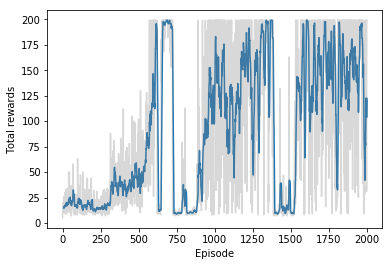

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

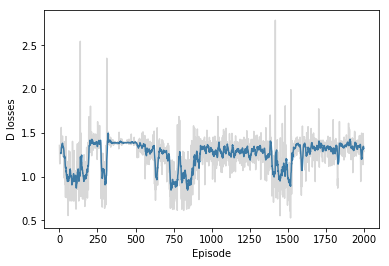

In [24]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

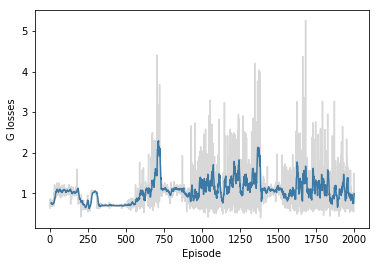

In [25]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

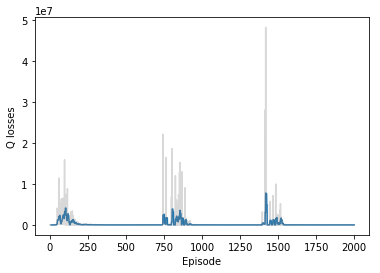

In [26]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [27]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


In [28]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.